# Demonstrate Use

In [1]:
import os
os.chdir("/Users/jen/watttime-python-client")

from watttime.api import RequerySimulator, WattTimeForecast
from datetime import timedelta, datetime
from pytz import UTC
import pandas as pd

In [2]:
def get_forecast_dataframe(
          start_time: datetime = datetime(2025, 1, 1, hour=20, second=1, tzinfo=UTC),
          end_time: datetime = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC),
          horizon_hours: int = 12,
          region: str = 'CAISO_NORTH'
        ) -> pd.DataFrame:
        try:
            username = os.getenv("WATTTIME_USER")
            password = os.getenv("WATTTIME_PASSWORD")
            
            if not username or not password:
                raise ValueError("WattTime credentials not found in environment variables")
                
            wth = WattTimeForecast(username=username, password=password)
            
            forecast_dataframe = wth.get_historical_forecast_pandas(
                start=start_time + timedelta(minutes=5),
                end=end_time,
                region=region,
                signal_type="co2_moer",
                horizon_hours=horizon_hours
            )
        except Exception as e:
            raise RuntimeError(f"Error retrieving forecast data: {str(e)}")
        
        return forecast_dataframe

In [3]:
start_time = datetime(2025, 1, 1, hour=20, second=1, tzinfo=UTC)
end_time = datetime(2025, 1, 2, hour=8, second=1, tzinfo=UTC)
region = 'CAISO_NORTH'

moers = get_forecast_dataframe(start_time=start_time, end_time=end_time, region=region)
requery_dates = moers.generated_at.unique()[0::4]

moers_list = []
for d in requery_dates:
    temp = moers[moers.generated_at == d]
    moers_list.append(temp)

In [4]:
fitted_recalculator = RequerySimulator(
                                    moers_list,
                                    requery_dates,
                                    region = "CAISO_NORTH",
                                    window_start = start_time,
                                    window_end = end_time,
                                    usage_time_required_minutes = 240,
                                    usage_power_kw = 2
                                    ).simulate()

None
== Simple fit! ==
1
None
== Simple fit! ==
2025-01-01 20:00:01+00:00
2025-01-01 20:30:00+00:00
2
None
== Simple fit! ==
2025-01-01 20:30:00+00:00
2025-01-01 20:50:00+00:00
3
None
== Simple fit! ==
2025-01-01 20:50:00+00:00
2025-01-01 21:10:00+00:00
4
None
== Simple fit! ==
2025-01-01 21:10:00+00:00
2025-01-01 21:30:00+00:00
5
None
== Simple fit! ==
2025-01-01 21:30:00+00:00
2025-01-01 21:50:00+00:00
6
None
== Simple fit! ==
2025-01-01 21:50:00+00:00
2025-01-01 22:10:00+00:00
7
None
== Simple fit! ==
2025-01-01 22:10:00+00:00
2025-01-01 22:30:00+00:00
8
None
== Simple fit! ==
2025-01-01 22:30:00+00:00
2025-01-01 22:50:00+00:00
9
None
== Simple fit! ==
2025-01-01 22:50:00+00:00
2025-01-01 23:10:00+00:00
10
None
== Simple fit! ==
2025-01-01 23:10:00+00:00
2025-01-01 23:30:00+00:00
11
None
== Simple fit! ==
2025-01-01 23:30:00+00:00
2025-01-01 23:50:00+00:00
12
None
== Simple fit! ==
2025-01-01 23:50:00+00:00
2025-01-02 00:10:00+00:00
13
None
== Simple fit! ==
2025-01-02 00:10:00+00:0

<Axes: xlabel='point_time'>

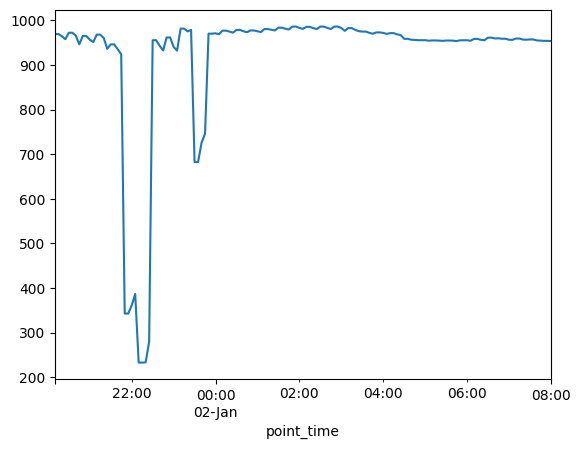

In [5]:
# this is really just to see what it decided to do -- for audit purposes.
# We assume that it follows each new schedule produced.
# Only one parameters updates: remaining time required
# You also need a timer or a list of future requery times are based on preferred frequency.
# Once the timer runs out and is reset OR the system time == next requery time, the a new schedule is produced.

fitted_recalculator.get_combined_schedule()["pred_moer"].plot(kind="line")

<Axes: xlabel='point_time'>

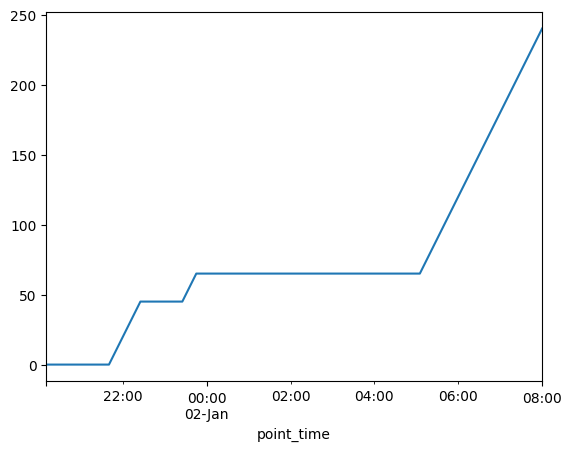

In [6]:
fitted_recalculator.get_combined_schedule()["usage"].cumsum().plot(kind="line")

In [16]:
fitted_recalculator.all_schedules[1][0]

,pred_moer,usage,emissions_co2e_lb,energy_usage_mwh
point_time,,,,
2025-01-01 20:30:00+00:00,972.2,0.0,0.0,0.0
2025-01-01 20:35:00+00:00,972.2,0.0,0.0,0.0
2025-01-01 20:40:00+00:00,965.7,0.0,0.0,0.0
2025-01-01 20:45:00+00:00,946.2,0.0,0.0,0.0
2025-01-01 20:50:00+00:00,942.1,0.0,0.0,0.0
...,...,...,...,...
2025-01-02 07:40:00+00:00,926.9,0.0,0.0,0.0
2025-01-02 07:45:00+00:00,926.8,0.0,0.0,0.0
2025-01-02 07:50:00+00:00,926.2,0.0,0.0,0.0


In [18]:
usage_plans = []
for i, df in enumerate(fitted_recalculator.all_schedules):
    usage_plans.append(fitted_recalculator.all_schedules[i][0]["usage"])

In [10]:
schedules_over_time = []
[schedules_over_time.append(fitted_recalculator.all_schedules[i]["usage"]) for i,df in fitted_recalculator.all_schedules]

TypeError: list indices must be integers or slices, not DataFrame

In [9]:
[print(x.usage) for x in fitted_recalculator.all_schedules]

AttributeError: 'tuple' object has no attribute 'usage'